In [1]:
import os 
import psycopg2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

In [2]:
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv('fire_var.env'))

True

In [3]:
# connect to postgres

try:
    conn = psycopg2.connect(database=os.environ.get("erdatabase"), user=os.environ.get("eruser"), 
                            password = os.environ.get("erpassword"), 
                            host=os.environ.get("erhost"), 
                            port=os.environ.get('port'))
    
except psycopg2.Error as e:
    print("I am unable to connect to the database")
    print(e)
    print(e.pgcode)
    print(e.pgerror)
    print(traceback.format_exc())

In [4]:
def pquery(QUERY):
    '''
    takes SQL query string, opens a cursor, and executes query in psql
    '''
    
    cur = conn.cursor()
    
    try:
        print("SQL QUERY = "+QUERY)
        cur.execute("SET statement_timeout = 0")
        cur.execute(QUERY)
        # Extract the column names and insert them in header
        col_names = []
        for elt in cur.description:
            col_names.append(elt[0])    
    
        D = cur.fetchall() #convert query result to list
        #pprint(D)
        #conn.close()
        # Create the dataframe, passing in the list of col_names extracted from the description
        return pd.DataFrame(D, columns=col_names)

    except Exception as e:
        print(e.pgerror)



In [ ]:
QUERY1= '''
SELECT incident_id,
 EXTRACT(DAY FROM realtime) AS day,
 EXTRACT(HOUR FROM realtime) AS hour,
 EXTRACT(WEEK FROM realtime) AS week,
 EXTRACT(MONTH FROM realtime) AS month,
 EXTRACT(YEAR FROM realtime) AS year
FROM (select incident_id,min(realtime) as realtime  from inctimes 
where responder_id is not null 
and timedesc_id = 3 group by incident_id) as dispatch_time'''

In [ ]:
# There are some instances that the On scene time subtracts dispatch time are negative or more than a day or month. 
# I assume these records are related to incidents, probably the time point error causes the weird travel time.
# So I picked all the incidents that have a dispatch time 
df1 = pquery(QUERY1)

In [ ]:
df1.head(15)

In [ ]:
# Check whether there is duplication
df1_ = df1.copy()
print (len(df1_))
df1_.set_index('incident_id').index.get_duplicates()

In [ ]:
dayrank = df1.groupby(['day']).size().to_frame('size')
dayrank.sort_values('size', ascending=False, inplace=True)
dayrank
plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
y_pos = np.arange(1,len(dayrank)+1)

ax.barh(y_pos, dayrank['size'], align='center',
        color='green')
ax.set_yticks(y_pos)
ax.set_yticklabels(dayrank.index.values)

ax.set_title('Incidents count in different days')

plt.show()

In [ ]:
weekrank = df1.groupby(['week']).size()
weekrank_df = pd.DataFrame(weekrank)
weekrank_df
weekrank_df.columns= ['size']
weekrank_df.plot(weekrank.index.values, "size", kind="barh", color=sns.color_palette("deep", 3))

In [ ]:
hourrank = df1.groupby(['hour']).size().to_frame('size')
hourrank.sort_values('size', ascending=False, inplace=True)
hourrank
fig3, ax3 = plt.subplots()

# Example data
y_pos3 = np.arange(1,len(hourrank)+1)

ax3.barh(y_pos3, hourrank['size'], align='center',
        color='green')
ax3.set_yticks(y_pos3)
ax3.set_yticklabels(hourrank.index.values)

#ax.set_xlabel('Performance')
ax3.set_title('Incidents count in different hours')

plt.show()

In [ ]:
hourrankByYear = df1.groupby(['year','hour']).size().reset_index()
hourrankByYear = pd.DataFrame(hourrankByYear)
hourrankByYear.columns= ['year','hour','size']
grouped2 = hourrankByYear.groupby(['year'])
grouped2_l = list(grouped2)

In [ ]:
for i in range(len(grouped2_l)-1):
    grouped2_l[i][1].iloc[:,-2:].plot(kind = 'bar',title = "year= "+str(int(grouped2_l[i][0])))
    # Shrink current axis by 20%
    ax = plt.subplot()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

In [ ]:
monthrank = df1.groupby(['month']).size().to_frame('size')
monthrank.sort_values('size', ascending=False, inplace=True)
monthrank
fig4, ax4 = plt.subplots()

# Example data
y_pos4 = np.arange(1,len(monthrank)+1)

ax4.barh(y_pos4, monthrank['size'], align='center',
        color='green')
ax4.set_yticks(y_pos4)
ax4.set_yticklabels(monthrank.index.values)

#ax.set_xlabel('Performance')
ax4.set_title('Incidents count in different months')

plt.show()


In [ ]:
monthrankByYear = df1.groupby(['year','month']).size().reset_index()
monthrankByYear = pd.DataFrame(monthrankByYear)
monthrankByYear.columns= ['year','month','size']
grouped = monthrankByYear.groupby(['year'])
grouped_l = list(grouped)




In [ ]:
for i in range(len(grouped_l)-1):
    grouped_l[i][1].iloc[:,-2:].plot(kind = 'bar',title = "year= "+str(int(grouped_l[i][0])))
    # Shrink current axis by 20%
    ax = plt.subplot()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])




In [ ]:
QUERY2 ="""
select incident_id, holiday 
from (SELECT incident_id, CAST(realtime AS DATE) 
      FROM (select incident_id,min(realtime) as realtime
            from inctimes 
             where responder_id is not null 
                   and timedesc_id = 3 group by incident_id ) as dispatch_time) as date_table
                   inner join or_holidays
                   on date_table.realtime = or_holidays.date"""

In [ ]:
df2 = pquery(QUERY2)

In [ ]:
df2.head()

In [ ]:
holidayrank = df2.groupby(['holiday']).size().to_frame('size')
holidayrank.sort_values('size', ascending=False, inplace=True)
holidayrank


In [ ]:
holidayrank_df = pd.DataFrame(holidayrank)
holidayrank_df.columns= ['size']
holidayrank_df.plot(holidayrank.index.values, "size", kind="barh", color=sns.color_palette("deep"))

In [11]:
QUERY3="""
        SELECT incident_id,incsitfoundclass_id, description,realtime,
                         EXTRACT(DAY FROM realtime) AS day,
                         EXTRACT(HOUR FROM realtime) AS hour,
                         EXTRACT(WEEK FROM realtime) AS week,
                         EXTRACT(MONTH FROM realtime) AS month,
                         EXTRACT(YEAR FROM realtime) AS year
                         FROM
                        (SELECT  I.incident_id,S_class.incsitfoundclass_id, S_class.description,T.realtime
                        FROM incident as I
                        INNER JOIN incsitfound as S
                                ON I.incsitfoundprm_id = S.incsitfound_id
                        INNER JOIN incsitfoundsub as S_sub
                                ON S.incsitfoundsub_id = S_sub.incsitfoundsub_id
                        INNER JOIN incsitfoundclass as S_class
                                ON S_sub.incsitfoundclass_id = S_class.incsitfoundclass_id
                        INNER JOIN inctimes as T
                                ON I.incident_id = T.incident_id
                        where T.responder_id is not null and T.timedesc_id = 3 
                        ) as dispatch_class_time 
                        ;"""


In [12]:
df3 = pquery(QUERY3)

SQL QUERY = 
        SELECT incident_id,incsitfoundclass_id, description,realtime,
                         EXTRACT(DAY FROM realtime) AS day,
                         EXTRACT(HOUR FROM realtime) AS hour,
                         EXTRACT(WEEK FROM realtime) AS week,
                         EXTRACT(MONTH FROM realtime) AS month,
                         EXTRACT(YEAR FROM realtime) AS year
                         FROM
                        (SELECT  I.incident_id,S_class.incsitfoundclass_id, S_class.description,T.realtime
                        FROM incident as I
                        INNER JOIN incsitfound as S
                                ON I.incsitfoundprm_id = S.incsitfound_id
                        INNER JOIN incsitfoundsub as S_sub
                                ON S.incsitfoundsub_id = S_sub.incsitfoundsub_id
                        INNER JOIN incsitfoundclass as S_class
                                ON S_sub.incsitfoundclass_id = S_class.incsitfoundclass_id
        

In [ ]:
df3.head(20)

In [13]:
# drop duplicates in 'incident_id'
 
df3 =df3.drop_duplicates('incident_id')
len(df3)

512276

In [14]:
df3_ = df3.loc[df3['incsitfoundclass_id']==3]
len(df3_)

368084

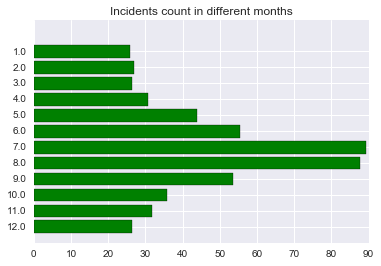

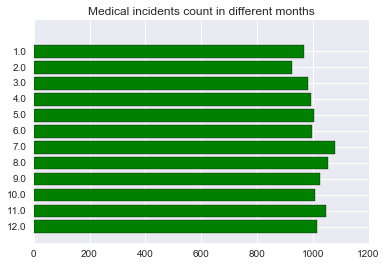

In [27]:
# get the fire and medical incidents counts
# normalized by number of days in different months
# fire incidents definitely happened more in July and August, there is no particularly high or low month for medical incidents

df3_ = df3.loc[df3['incsitfoundclass_id']==3]
df3_f = df3.loc[df3['incsitfoundclass_id']==1]


days_in_month = [31,28,31,30,31,30,31,31,30,31,30,31]
days_in_month = np.array(days_in_month)

monthrank2 = df3_f.groupby(['month']).size().to_frame('size')
monthrank2.sort_values('size', ascending=False, inplace=True)
monthrank2.sort_index(ascending=False, inplace=True)
monthrank2['size'] = monthrank2['size']/days_in_month

monthrank3 = df3_.groupby(['month']).size().to_frame('size')
monthrank3.sort_values('size', ascending=False, inplace=True)
monthrank3.sort_index(ascending=False,inplace=True)
monthrank3['size'] = monthrank3['size']/days_in_month

fig5, ax5= plt.subplots()
fig6, ax6= plt.subplots()

# Example data
y_pos5 = np.arange(1,len(monthrank2)+1)

ax5.barh(y_pos5, monthrank2['size'], align='center',
        color='green')
ax5.set_yticks(y_pos5)
ax5.set_yticklabels(monthrank2.index.values)

#ax.set_xlabel('Performance')
ax5.set_title('Fire incidents count in different months')


ax6.barh(y_pos5, monthrank3['size'], align='center',
        color='green')
ax6.set_yticks(y_pos5)
ax6.set_yticklabels(monthrank3.index.values)

#ax.set_xlabel('Performance')
ax6.set_title('Medical incidents count in different months')


plt.show()

